# Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as skpp
import imblearn.over_sampling as imbp
import sklearn.neighbors as skkn
import sklearn.metrics as skmt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Read the data
df = pd.read_csv("employee_promotion_updated.csv")

# Clean the data
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Create a mapping dictionary for categorical variables
valueKeyMapping = dict()

def convert_to_numeric(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {unique_values[i]: i for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)

def convert_to_string(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {i: unique_values[i] for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)

for column in df.columns:
    if df[column].dtype == np.dtype("object"):
        unique_values = df[column].unique()
        valueKeyMapping[column] = unique_values

        convert_to_numeric(column, df)

# Display descriptive statistics
print("Dataset Description:")
display(df.head())

# Interaction features
df["perf_training"] = df["previous_year_rating"] * df["avg_training_score"]
df["experience_score"] = df["length_of_service"] * df["avg_training_score"]

# Ratio features
df["rating_per_service"] = df["previous_year_rating"] / (df["length_of_service"] + 1)

# Department-specific features
dept_promotion_rates = df.groupby("department")["is_promoted"].mean()
df["dept_promotion_rate"] = df["department"].map(dept_promotion_rates)

df.drop(columns=["employee_id"], inplace=True)

Dataset Description:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,0,0,0,0,0,1,35,5.0,8,0,49.0,0
1,65141,1,1,1,1,1,1,30,5.0,4,0,60.0,0
2,7513,0,2,1,1,0,1,34,3.0,7,0,50.0,0
3,2542,0,3,1,1,1,2,39,1.0,10,0,50.0,0
4,48945,2,4,1,1,1,1,45,3.0,2,0,73.0,0


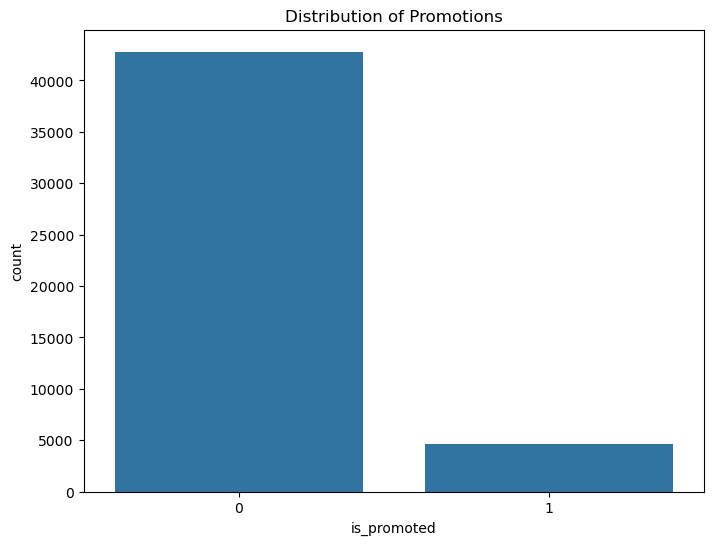

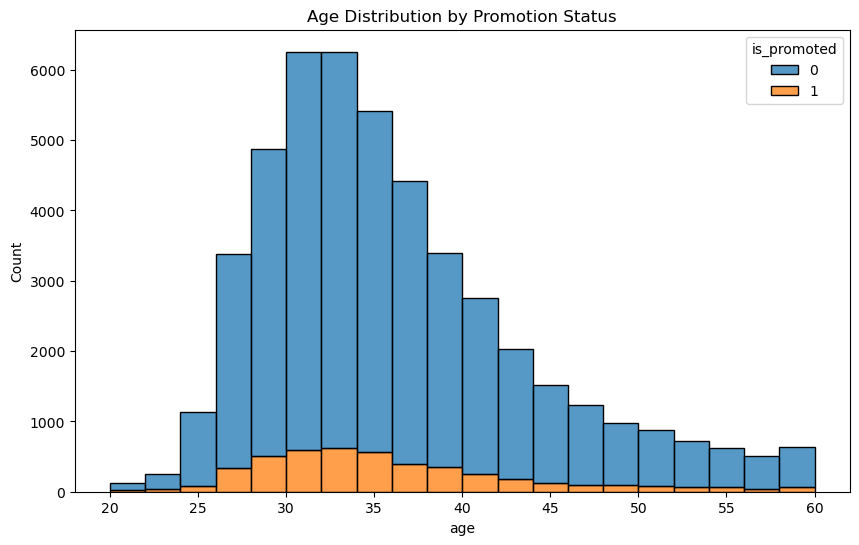

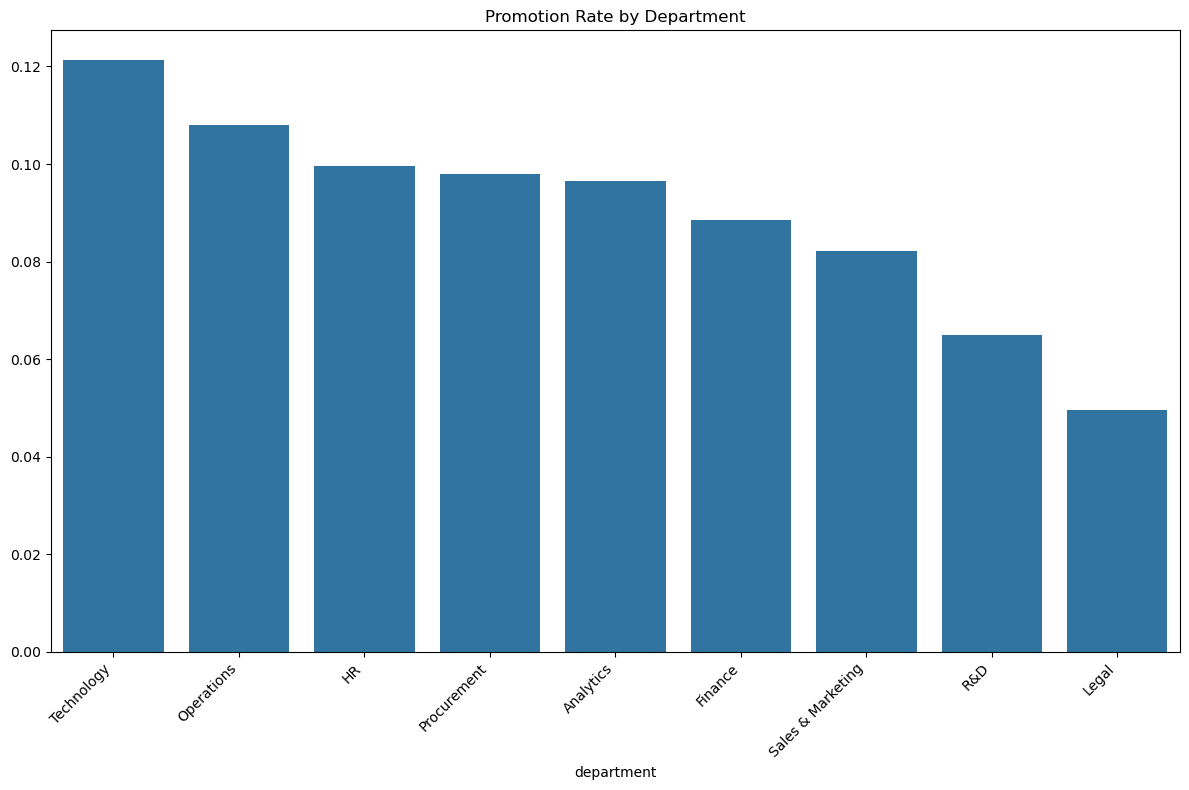

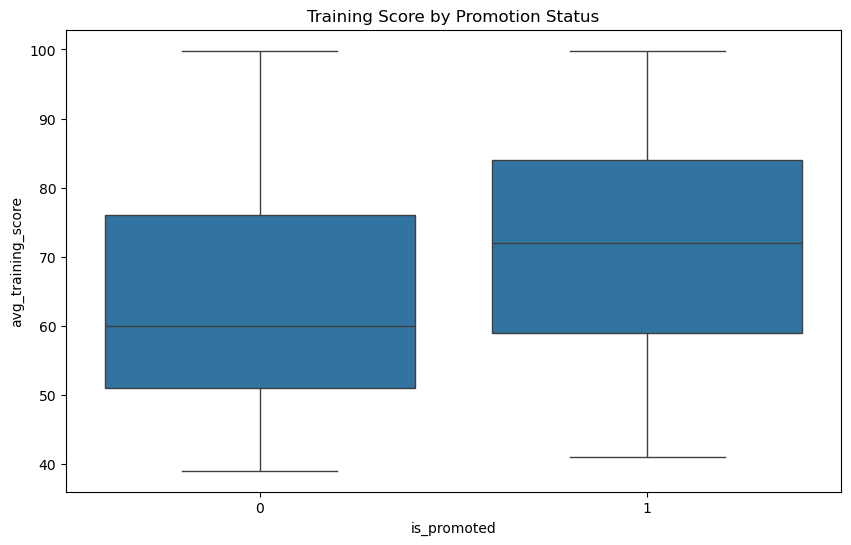

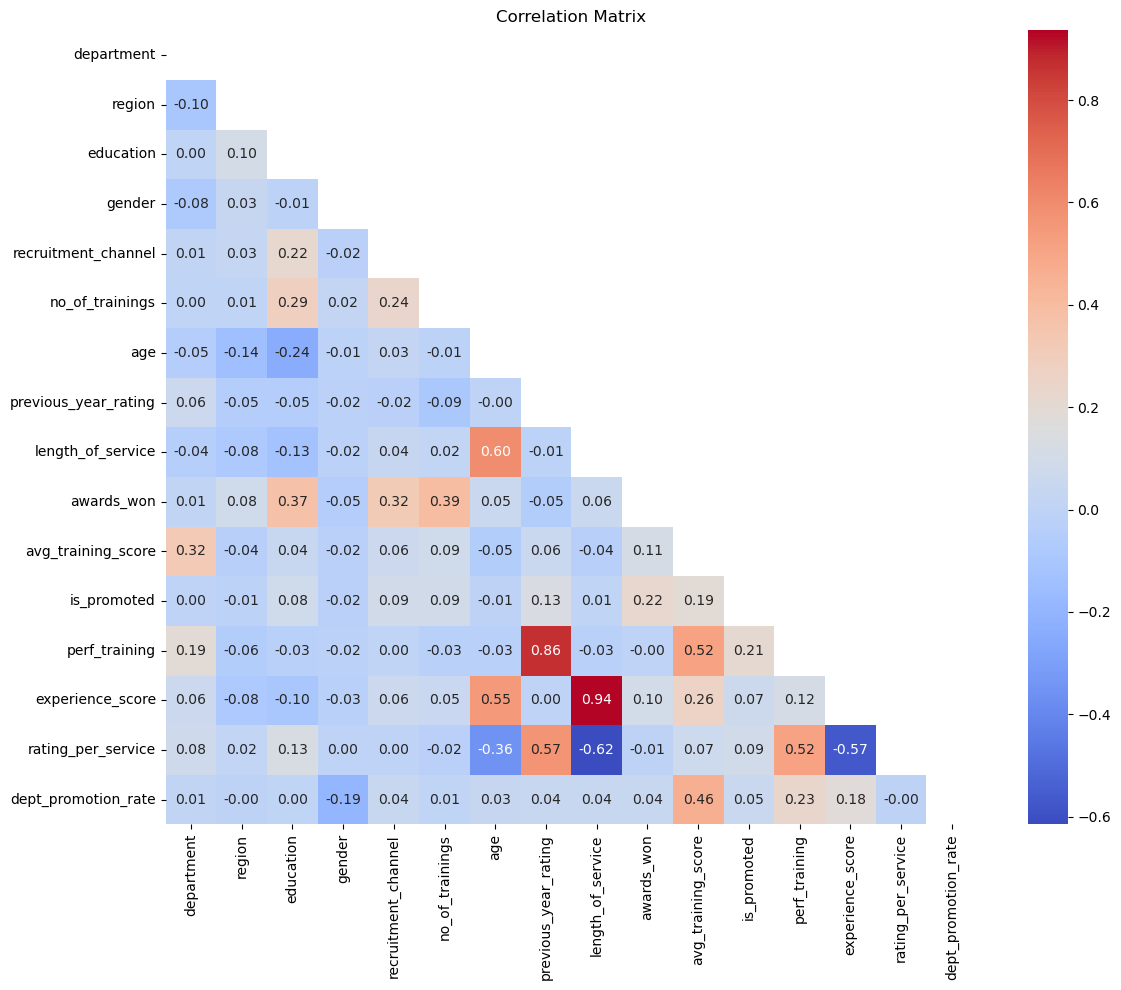

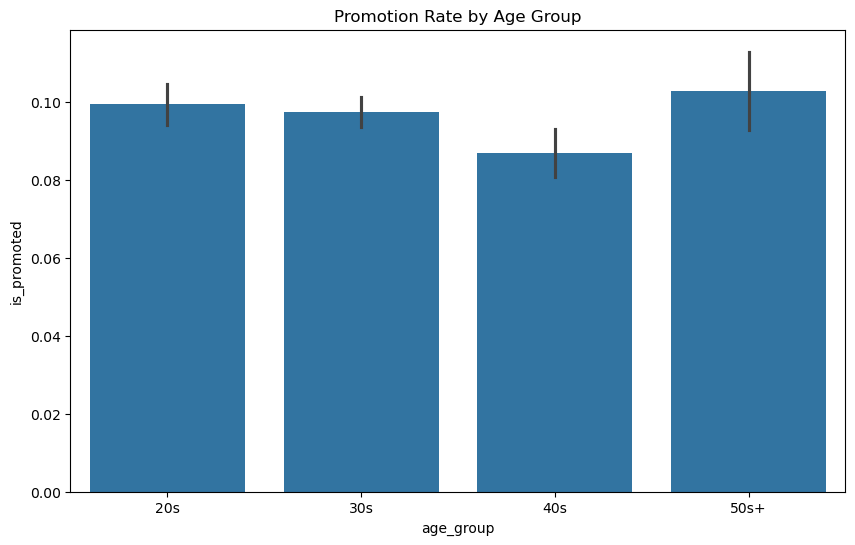

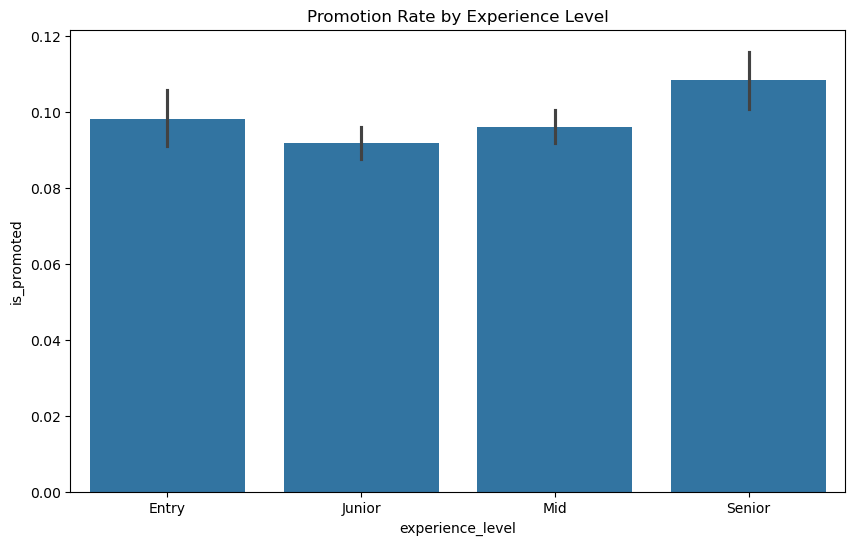

In [5]:
## Explanatory Data Analysis
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_promoted', data=df)
plt.title('Distribution of Promotions')
plt.show()

# Age distribution by promotion status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='is_promoted', multiple='stack', bins=20)
plt.title('Age Distribution by Promotion Status')
plt.show()

convert_to_string("department", df)
plt.figure(figsize=(12, 8))
dept_promotion = (
    df.groupby("department", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=dept_promotion.index, y=dept_promotion.values)
plt.title('Promotion Rate by Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

convert_to_numeric("department", df)

# Boxplot of training scores by promotion status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_promoted', y='avg_training_score', data=df)
plt.title('Training Score by Promotion Status')
plt.show()


# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

df_copy = df.copy()
# Create age groups
df_copy["age_group"] = pd.cut(
    df["age"], bins=[20, 30, 40, 50, 60], labels=["20s", "30s", "40s", "50s+"]
)

# Create experience level categories
df_copy["experience_level"] = pd.cut(
    df["length_of_service"],
    bins=[0, 2, 5, 10, 30],
    labels=["Entry", "Junior", "Mid", "Senior"],
)

# Analyze promotion rates by age group and experience level
plt.figure(figsize=(10, 6))
sns.barplot(x="age_group", y="is_promoted", data=df_copy)
plt.title('Promotion Rate by Age Group')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="experience_level", y="is_promoted", data=df_copy)
plt.title('Promotion Rate by Experience Level')
plt.show()

# Add engineered features that might capture promotion patterns



Original data shape: (47380, 16)
Clean data shape: (45011, 16)
Removed 2369 outliers (5.00%)


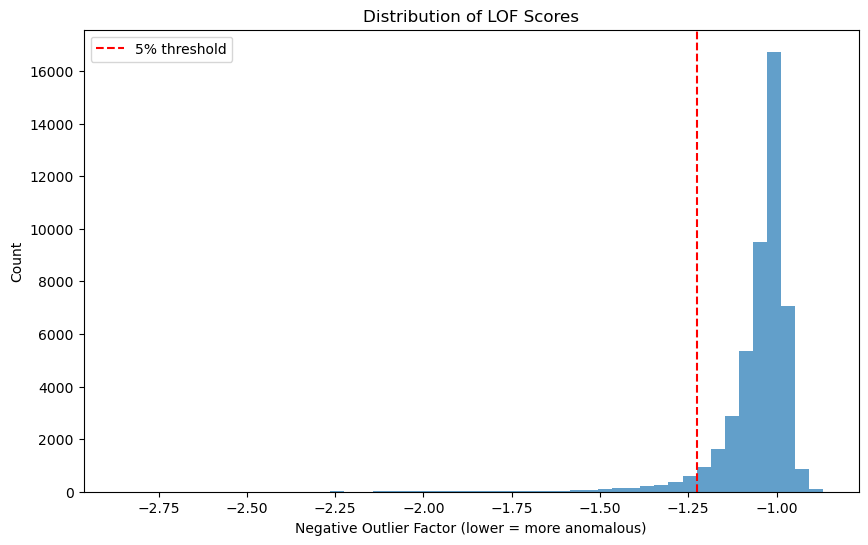

In [6]:
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers_lof(df, columns, contamination=0.05):
    """
    Remove outliers using Local Outlier Factor
    
    Args:
        df: DataFrame
        columns: List of columns to use for outlier detection
        contamination: Expected proportion of outliers (default=0.05)
    
    Returns:
        DataFrame with outliers removed, and the outlier scores
    """
    df_clean = df.copy()
    
    # Extract features for outlier detection
    X = df_clean[columns].values
    
    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    y_pred = lof.fit_predict(X)
    
    # Negative outlier factor: lower = more anomalous
    outlier_scores = lof.negative_outlier_factor_
    
    # Keep only inliers (labeled as 1)
    df_clean = df_clean[y_pred == 1]
    
    print(f"Original data shape: {df.shape}")
    print(f"Clean data shape: {df_clean.shape}")
    print(f"Removed {df.shape[0] - df_clean.shape[0]} outliers ({((df.shape[0] - df_clean.shape[0])/df.shape[0])*100:.2f}%)")
    
    return df_clean, outlier_scores

# Example usage with numeric columns
numeric_cols = ['age', 'length_of_service', 'avg_training_score', 'no_of_trainings', 'previous_year_rating']
df_no_outliers, outlier_scores = remove_outliers_lof(df, numeric_cols, contamination=0.05)

# You can also visualize the distribution of outlier scores
plt.figure(figsize=(10, 6))
plt.hist(outlier_scores, bins=50, alpha=0.7)
plt.axvline(x=np.percentile(outlier_scores, 5), color='red', linestyle='--', label='5% threshold')
plt.title('Distribution of LOF Scores')
plt.xlabel('Negative Outlier Factor (lower = more anomalous)')
plt.ylabel('Count')
plt.legend()
plt.show()

Percentage of promotions among outliers vs non-outliers:
is_promoted         0         1
is_outlier                     
False        0.908378  0.091622
True         0.805403  0.194597


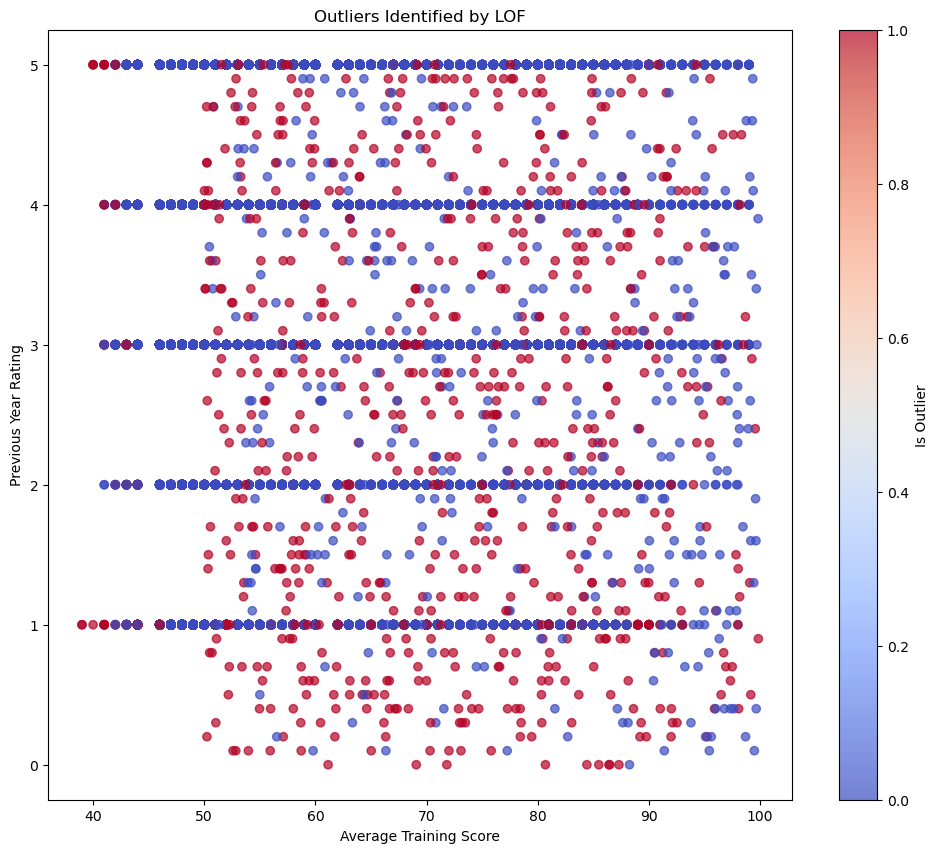

In [7]:
# Apply LOF but don't remove yet
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_predictions = lof.fit_predict(df[numeric_cols].values)
outlier_scores = lof.negative_outlier_factor_

# Add outlier information to dataframe
df_with_outliers = df.copy()
df_with_outliers['is_outlier'] = outlier_predictions == -1
df_with_outliers['outlier_score'] = outlier_scores

# Examine how outliers relate to promotions
promotion_outlier_table = pd.crosstab(df_with_outliers['is_outlier'], 
                                      df_with_outliers['is_promoted'], 
                                      normalize='index')
print("Percentage of promotions among outliers vs non-outliers:")
print(promotion_outlier_table)

# Visualize outliers vs non-outliers
plt.figure(figsize=(12, 10))
plt.scatter(df_with_outliers['avg_training_score'], 
           df_with_outliers['previous_year_rating'],
           c=outlier_predictions == -1, 
           cmap='coolwarm',
           alpha=0.7)
plt.colorbar(label='Is Outlier')
plt.xlabel('Average Training Score')
plt.ylabel('Previous Year Rating')
plt.title('Outliers Identified by LOF')
plt.show()

Characteristics of promoted non-outliers:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,perf_training,experience_score,rating_per_service,dept_promotion_rate,outlier_score
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.0,4124.000000,4124.00000,4124.000000,4124.000000,4124.000000
mean,2.270369,9.257274,0.747575,0.669496,0.687197,1.260669,35.267459,3.929801,6.274491,0.198109,71.954248,1.0,282.944051,449.89015,0.705223,0.098804,-1.037197
std,2.142483,8.397735,0.690925,0.470452,0.756007,0.837628,7.258105,1.095838,4.066250,0.563491,14.685054,0.0,100.136451,309.48620,0.413117,0.014734,0.057678
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,42.000000,1.0,0.000000,0.00000,0.000000,0.049673,-1.224709
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,30.000000,3.000000,3.000000,0.000000,59.000000,1.0,208.000000,234.00000,0.400000,0.082094,-1.067474
50%,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,34.000000,4.000000,5.000000,0.000000,72.000000,1.0,275.000000,365.00000,0.625000,0.098057,-1.024295
75%,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,39.000000,5.000000,8.000000,0.000000,84.000000,1.0,360.000000,568.00000,1.000000,0.107955,-0.997633
max,8.000000,33.000000,4.000000,1.000000,5.000000,9.000000,60.000000,5.000000,32.000000,4.000000,99.820000,1.0,495.000000,2494.00000,3.800000,0.121343,-0.887951


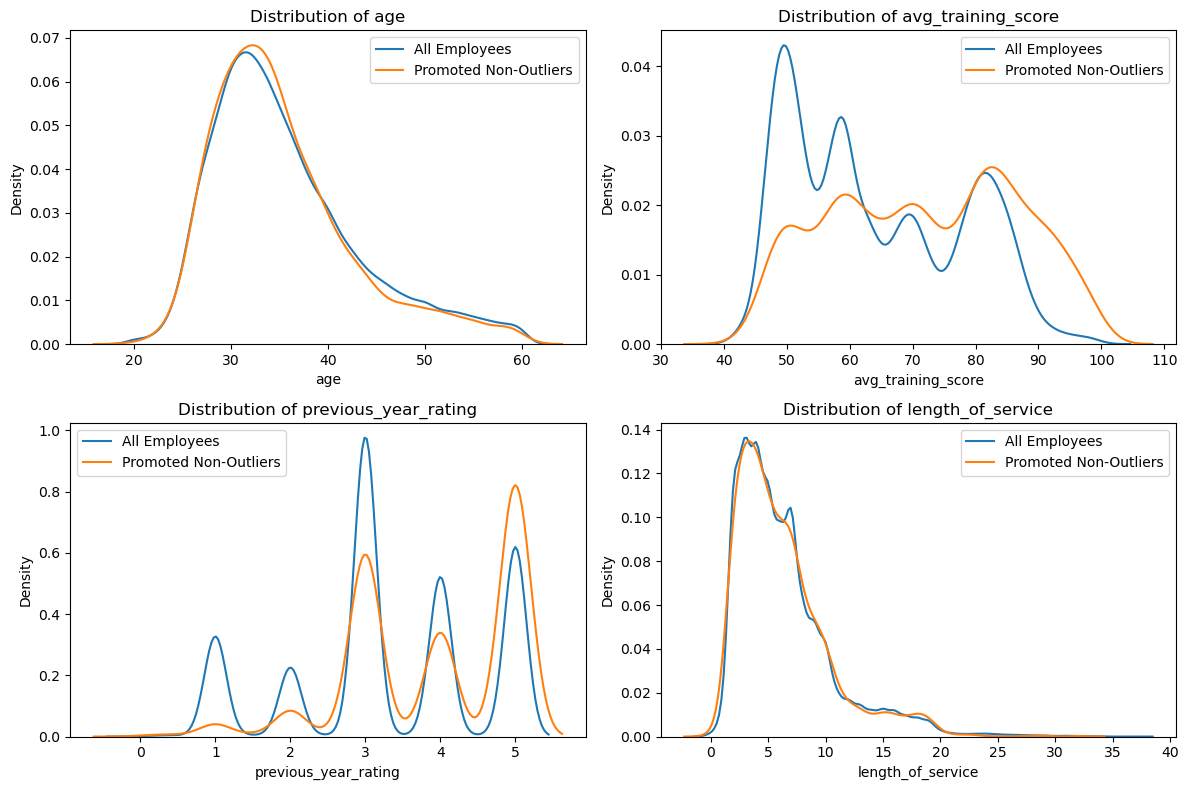

In [8]:
# Extract promoted non-outliers for analysis
promoted_non_outliers = df_with_outliers[
    (df_with_outliers["is_promoted"] == 1) & (df_with_outliers["is_outlier"] == False)
]

# Analyze their characteristics
print("Characteristics of promoted non-outliers:")
display(promoted_non_outliers.describe())

# Compare to all employees
plt.figure(figsize=(12, 8))
for i, col in enumerate(
    ["age", "avg_training_score", "previous_year_rating", "length_of_service"]
):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[col], label="All Employees")
    sns.kdeplot(promoted_non_outliers[col], label="Promoted Non-Outliers")
    plt.title(f"Distribution of {col}")
    plt.legend()
plt.tight_layout()
plt.show()

In [9]:

train, valid, test = np.split(
    df.sample(frac=1),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)

train_samples = np.array_split(train, 10)
valid_samples = np.array_split(valid, 10)
test_samples = np.array_split(test, 5)

/home/diogo/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def prepare_data(df, oversample=False):
    data = df[df.columns.difference(['is_promoted'])].values
    target = df['is_promoted'].values
    
    scaler = skpp.StandardScaler()
    data = scaler.fit_transform(data)
    
    if oversample:
        ros = imbp.RandomOverSampler()
        data, target = ros.fit_resample(data, target)
    
    dataset = np.hstack((data, np.reshape(target, (-1, 1))))
    
    return dataset, data, target

def prepare_train_test_split(df):
    # Split data into outliers and non-outliers
    outliers = df[df['is_outlier'] == True].drop(['is_outlier', 'outlier_score'], axis=1)
    non_outliers = df[df['is_outlier'] == False].drop(['is_outlier', 'outlier_score'], axis=1)
    
    # Create training and test sets for each
    from sklearn.model_selection import train_test_split
    X_outlier = outliers.drop('is_promoted', axis=1)
    y_outlier = outliers['is_promoted']
    X_regular = non_outliers.drop('is_promoted', axis=1)
    y_regular = non_outliers['is_promoted']
    
    X_outlier_train, X_outlier_test, y_outlier_train, y_outlier_test = train_test_split(
        X_outlier, y_outlier, test_size=0.3, random_state=42
    )
    
    X_regular_train, X_regular_test, y_regular_train, y_regular_test = train_test_split(
        X_regular, y_regular, test_size=0.3, random_state=42
    )
    
    scaler = skpp.StandardScaler()
    X_regular_train = scaler.fit_transform(X_regular_train)
    X_regular_test = scaler.transform(X_regular_test)
        
    scaler_outlier = skpp.StandardScaler()
    X_outlier_train = scaler_outlier.fit_transform(X_outlier_train)
    X_outlier_test = scaler_outlier.transform(X_outlier_test)
    
    return (X_regular_train, X_regular_test, y_regular_train, y_regular_test), \
           (X_outlier_train, X_outlier_test, y_outlier_train, y_outlier_test)

In [11]:
train, valid, test = train_samples[0], valid_samples[0], test_samples[0]

# train, train_features, train_target = prepare_data(train)
# valid, valid_features, valid_target = prepare_data(valid)
# test, test_features, test_target = prepare_data(test)

(X_regular_train, X_regular_test, y_regular_train, y_regular_test), (
    X_outlier_train,
    X_outlier_test,
    y_outlier_train,
    y_outlier_test,
) = prepare_train_test_split(df_with_outliers)

# from sklearn.model_selection import GridSearchCV

# # Example for Random Forest
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'class_weight': [None, 'balanced']
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(), param_grid, cv=3, scoring='f1',
#     verbose=1, n_jobs=-1
# )
# grid_search.fit(X_regular_train, y_regular_train)
# print("Best parameters:", grid_search.best_params_)

print("Training set size:", len(X_regular_train))
print("Validation set size:", len(X_regular_test))
print("Test set size:", len(test))
# Show proportion of promoted employees in the training target
print(
    "Proportion of promoted employees in training set:",
    np.mean(y_regular_test == 1)
)

Training set size: 31507
Validation set size: 13504
Test set size: 1896
Proportion of promoted employees in training set: 0.09797097156398105



--- KNN Results ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     12181
           1       0.55      0.13      0.21      1323

    accuracy                           0.90     13504
   macro avg       0.73      0.56      0.58     13504
weighted avg       0.88      0.90      0.88     13504

[[12045   136]
 [ 1154   169]]


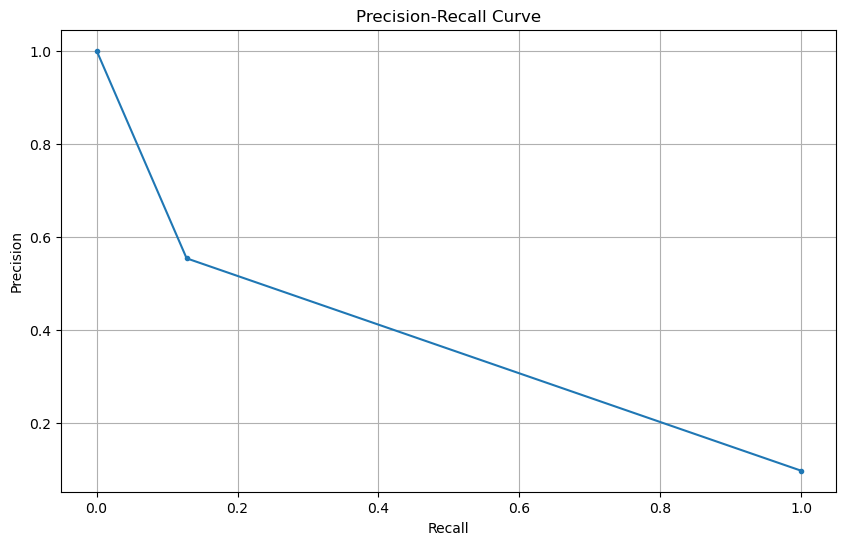


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12181
           1       0.64      0.41      0.50      1323

    accuracy                           0.92     13504
   macro avg       0.79      0.69      0.73     13504
weighted avg       0.91      0.92      0.91     13504

[[11878   303]
 [  785   538]]


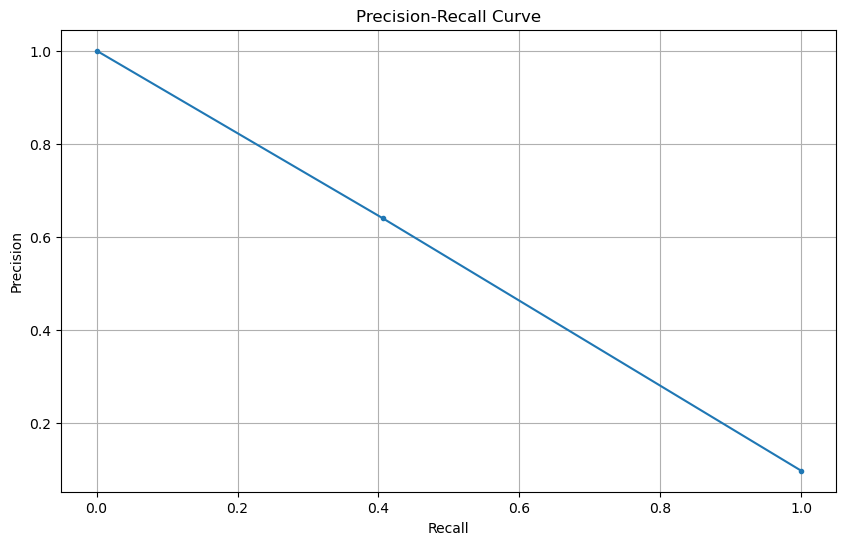


--- Gradient Boosting Results ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12181
           1       0.90      0.28      0.42      1323

    accuracy                           0.93     13504
   macro avg       0.91      0.64      0.69     13504
weighted avg       0.92      0.93      0.91     13504

[[12141    40]
 [  957   366]]


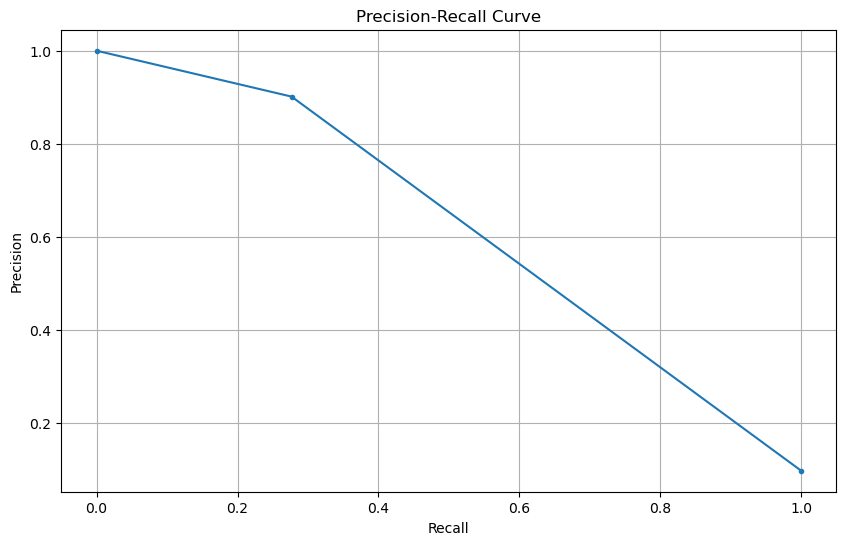


--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     12181
           1       0.20      0.68      0.30      1323

    accuracy                           0.70     13504
   macro avg       0.57      0.69      0.55     13504
weighted avg       0.88      0.70      0.76     13504

[[8495 3686]
 [ 429  894]]


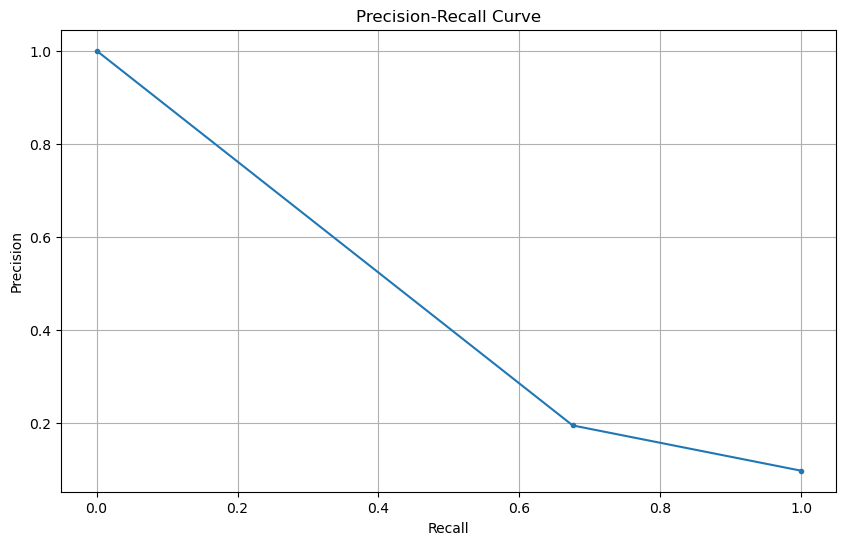


--- KNN Results ---
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       569
           1       0.55      0.43      0.48       142

    accuracy                           0.82       711
   macro avg       0.71      0.67      0.69       711
weighted avg       0.80      0.82      0.81       711

[[520  49]
 [ 81  61]]


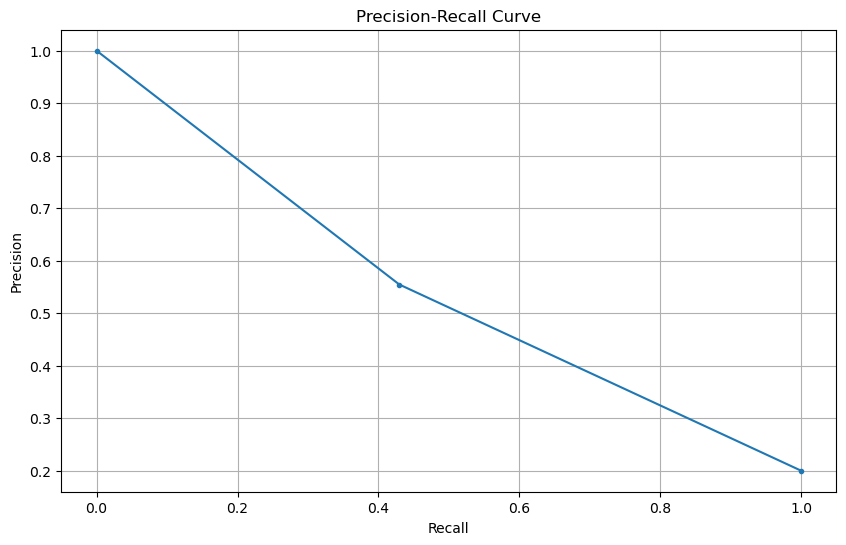


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       569
           1       0.58      0.73      0.65       142

    accuracy                           0.84       711
   macro avg       0.75      0.80      0.77       711
weighted avg       0.86      0.84      0.85       711

[[495  74]
 [ 39 103]]


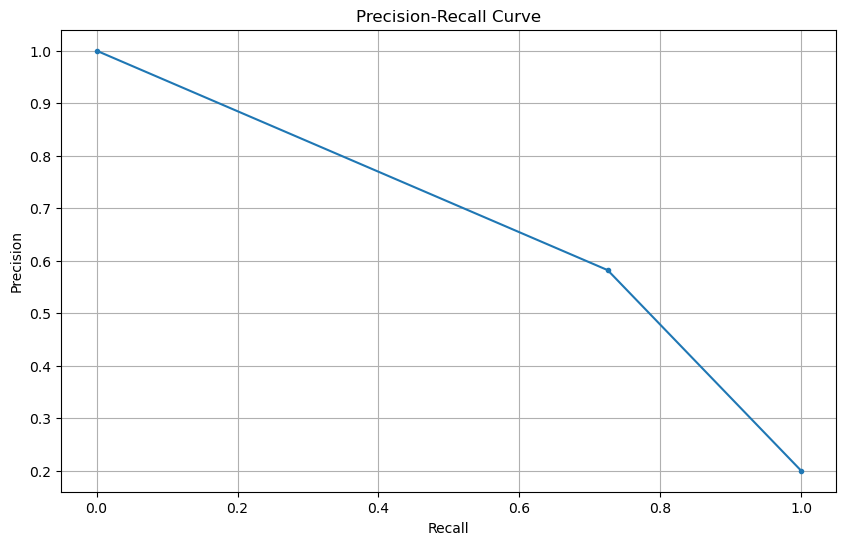


--- Gradient Boosting Results ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       569
           1       0.64      0.46      0.54       142

    accuracy                           0.84       711
   macro avg       0.76      0.70      0.72       711
weighted avg       0.83      0.84      0.83       711

[[532  37]
 [ 76  66]]


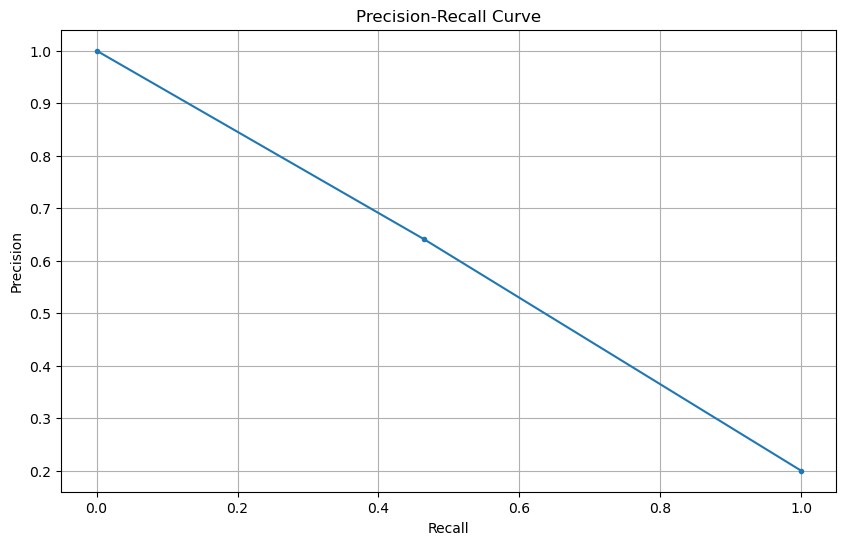


--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       569
           1       0.53      0.80      0.63       142

    accuracy                           0.82       711
   macro avg       0.73      0.81      0.76       711
weighted avg       0.86      0.82      0.83       711

[[467 102]
 [ 29 113]]


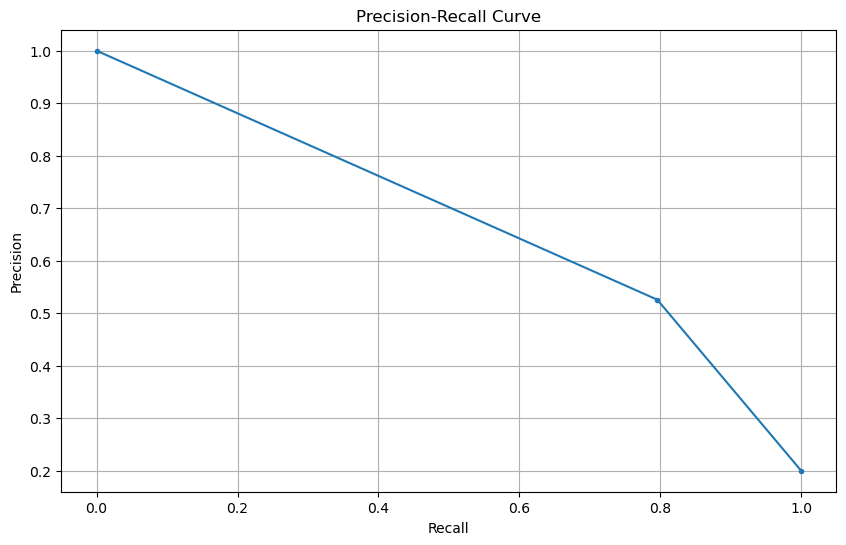

In [12]:
models = {
    "KNN": skkn.KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(class_weight="balanced", max_depth=None, min_samples_split=10, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
}

for (x_train, x_test, y_train, y_test) in [(X_regular_train, X_regular_test, y_regular_train, y_regular_test), (
    X_outlier_train,
    X_outlier_test,
    y_outlier_train,
    y_outlier_test
)]:
    for name, model in models.items():
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        print(f"\n--- {name} Results ---")
        print(skmt.classification_report(y_test, pred))
        print(skmt.confusion_matrix(y_test, pred))
        # Get prediction probabilities

        precision, recall, thresholds = precision_recall_curve(y_test, pred)

        # Plot precision-recall curve
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, marker=".")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.grid(True)
        plt.show()

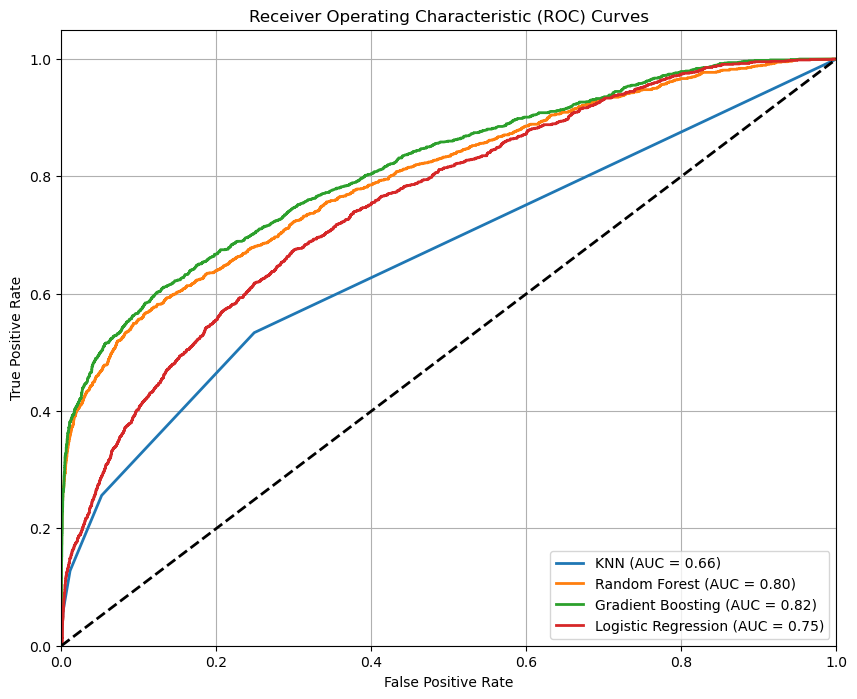

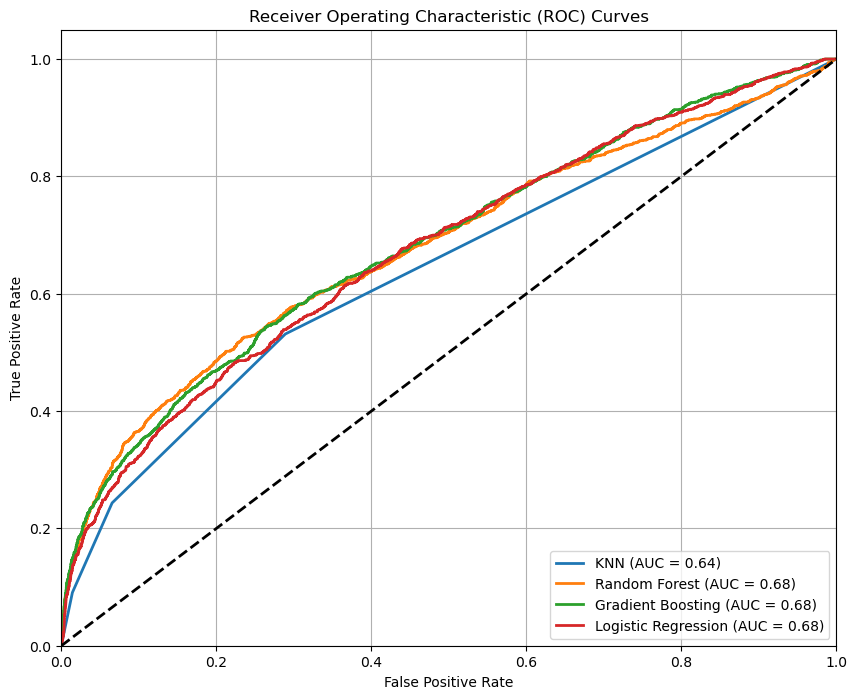

In [15]:
from sklearn.metrics import roc_curve, auc


# Function to plot ROC curves for all models
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Call the function for your trained models
models_fitted = {}
for name, model in models.items():
    model.fit(X_regular_train, y_regular_train)
    models_fitted[name] = model

plot_roc_curves(models_fitted, X_regular_test, y_regular_test)

models_fitted = {}
for name, model in models.items():
    model.fit(X_outlier_train, y_outlier_train)
    models_fitted[name] = model

plot_roc_curves(models_fitted, X_regular_test, y_regular_test)

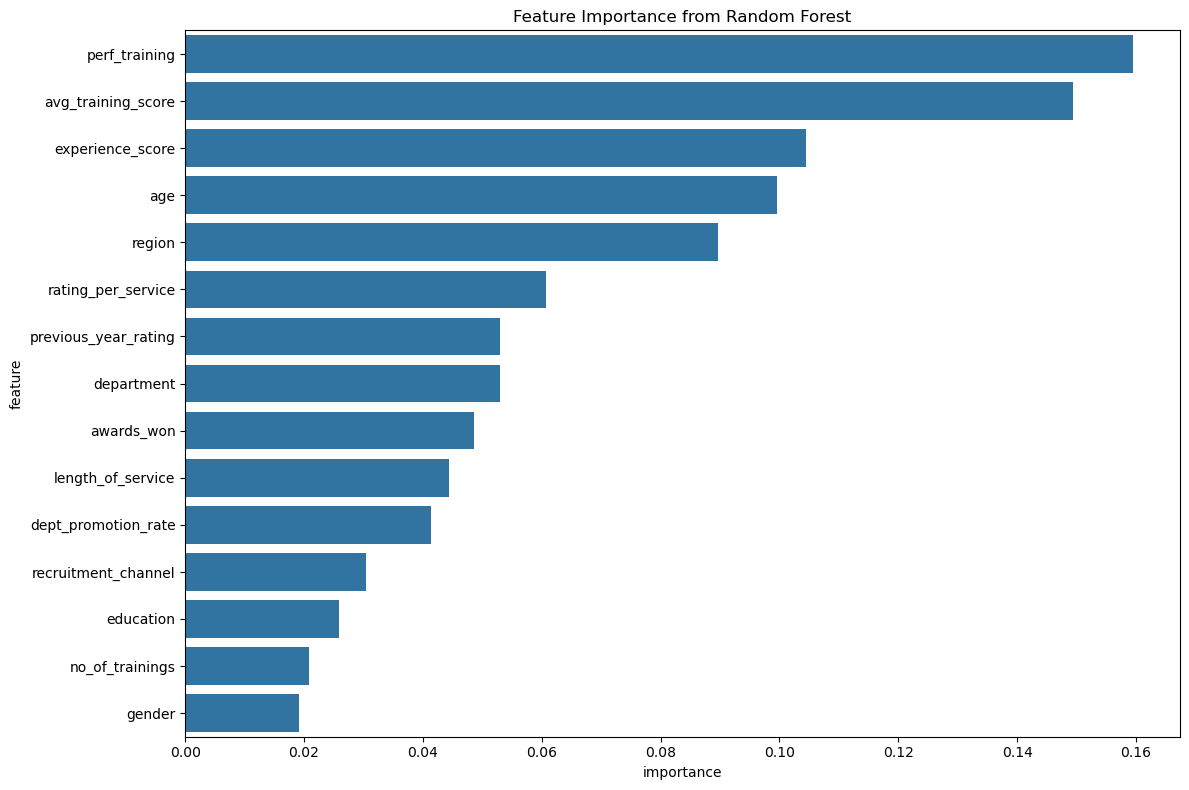

In [13]:
# For Random Forest
rf_model = models["Random Forest"]
rf_model.fit(X_regular_train, y_regular_train)

# Get feature importance
feature_names = df_with_outliers.drop(
    ["is_promoted", "is_outlier", "outlier_score"], axis=1
).columns
feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()